In [1]:
import os
from os.path import join

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from tqdm import tqdm
from utils.isoutil import *
from utils.misc import get_batches, save_params, load_params, get_data, get_polylines

from glob import glob
import pandas as pd
import json
from PIL import Image
import numpy as np
import scipy.stats as sps
from IPython.display import clear_output


import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib import cm

from sklearn.preprocessing import StandardScaler
from natsort import natsorted

matplotlib.use('agg')
from scipy.spatial import distance


In [2]:
# floor plan dataset with isovist samples
data_folder = 'floorplan_isovist_dataset\\cubicasa_dense_grid_full\\eval'
csvs = natsorted(glob(f'{data_folder}\\*.csv'))
poly_txt = natsorted(glob(f'{data_folder}\\*.txt'))
print(len(poly_txt), len(csvs))

450 450


In [3]:
# reference dataset isovist
data_path = 'floorplan_isovist_dataset\\cubicasa_isovist_numpy\\x_eval.npy'
isovist_eval_data = np.load(data_path)

In [4]:
# create folder for experiment results
folder = 'experiment\\03_variance_distribution_analysis'


folder_plan = f'{folder}\\plan'
if not os.path.isdir(folder_plan):
    os.makedirs(folder_plan)

folder_dist = f'{folder}\\dist'
if not os.path.isdir(folder_dist):
    os.makedirs(folder_dist)

In [5]:
# isovist occlusivity of reference dataset
variance = []
for isovist in tqdm(isovist_eval_data):
    isovist = isovist.flatten()
    variance.append(isovist_variance(isovist))
variance = np.asarray(variance)

variance = np.expand_dims(variance, 1)
variance.shape

100%|██████████| 34163/34163 [00:02<00:00, 15523.67it/s]


(34163, 1)

In [7]:
# normalizing reference dataset occlusivity
scaler_var = StandardScaler()
X_var = scaler_var.fit_transform(variance)
print(scaler_var.mean_)
print(np.sqrt(scaler_var.var_))

[0.08805338]
[0.03699522]


In [8]:
# get normalized variance from isovist samples

def get_variance(isovists):
    var = []
    for isovist in tqdm(isovists):
        isovist = isovist.flatten()
        var.append(isovist_variance(isovist))
    var = np.expand_dims(np.asarray(var), 1)
    normalized = scaler_var.transform(var)
    return normalized, var

In [10]:
# sample floor plam

name= csvs[i].split('\\')[-1].split('.')[0]
df = pd.read_csv(csvs[i])
scale, rad, loc, isovist = get_data(df)
isovists=np.expand_dims(isovist, axis=1)
values, norm = get_variance(isovists)
name

100%|██████████| 2328/2328 [00:00<00:00, 22383.11it/s]


'22-0'

In [11]:
# modified wasserstein distance
def modified_wsd(u, v, bins):
    u_values = u.flatten()
    v_values = v.flatten()
    u_sorter = np.argsort(u_values)
    v_sorter = np.argsort(v_values)

    u_cdf = u_values[u_sorter].searchsorted(bins[:-1], 'right')/u_values.size
    v_cdf = v_values[v_sorter].searchsorted(bins[:-1], 'right')/v_values.size
    delta = bins[1] - bins[0]
    return np.sum(np.multiply((u_cdf-v_cdf), delta))

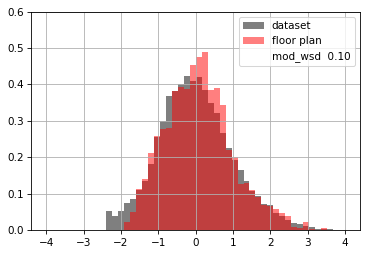

In [14]:
# plot probabiliy density function

%matplotlib inline

bins = np.linspace(-4, 4, 51)


fig, ax = plt.subplots(1,1, figsize=(5, 3.5), dpi=75)
p = ax.hist(X_var, bins, alpha=0.5, label='dataset', color='k', density=True)
q = ax.hist(values, bins, alpha=0.5, label='floor plan', color='red', density=True)
mod_wsd = modified_wsd(X_var, values, bins)
ax.plot([], [], ' ', label=f'mod_wsd  {mod_wsd:.2f}')
ax.grid(True)
ax.set_ylim(0, 0.6)
ax.legend(loc='upper right')
plt.tight_layout()

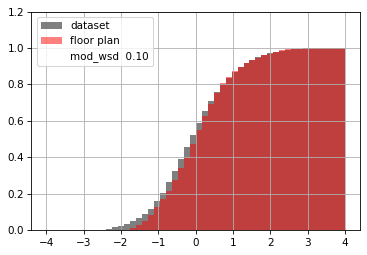

In [15]:
# plot cumulative distribution function 

fig, ax = plt.subplots(1,1, figsize=(5, 3.5), dpi=75)
p_cum = ax.hist(X_var, bins, alpha=0.5, label='dataset', color='k', density=True, cumulative=True)
q_cum = ax.hist(values, bins, alpha=0.5, label='floor plan', color='red', density=True, cumulative=True)
mod_wsd = modified_wsd(X_var, values, bins)
ax.plot([], [], ' ', label=f'mod_wsd  {mod_wsd:.2f}')
ax.grid(True)
ax.set_ylim(0, 1.2)
ax.legend(loc='upper left')
plt.tight_layout()

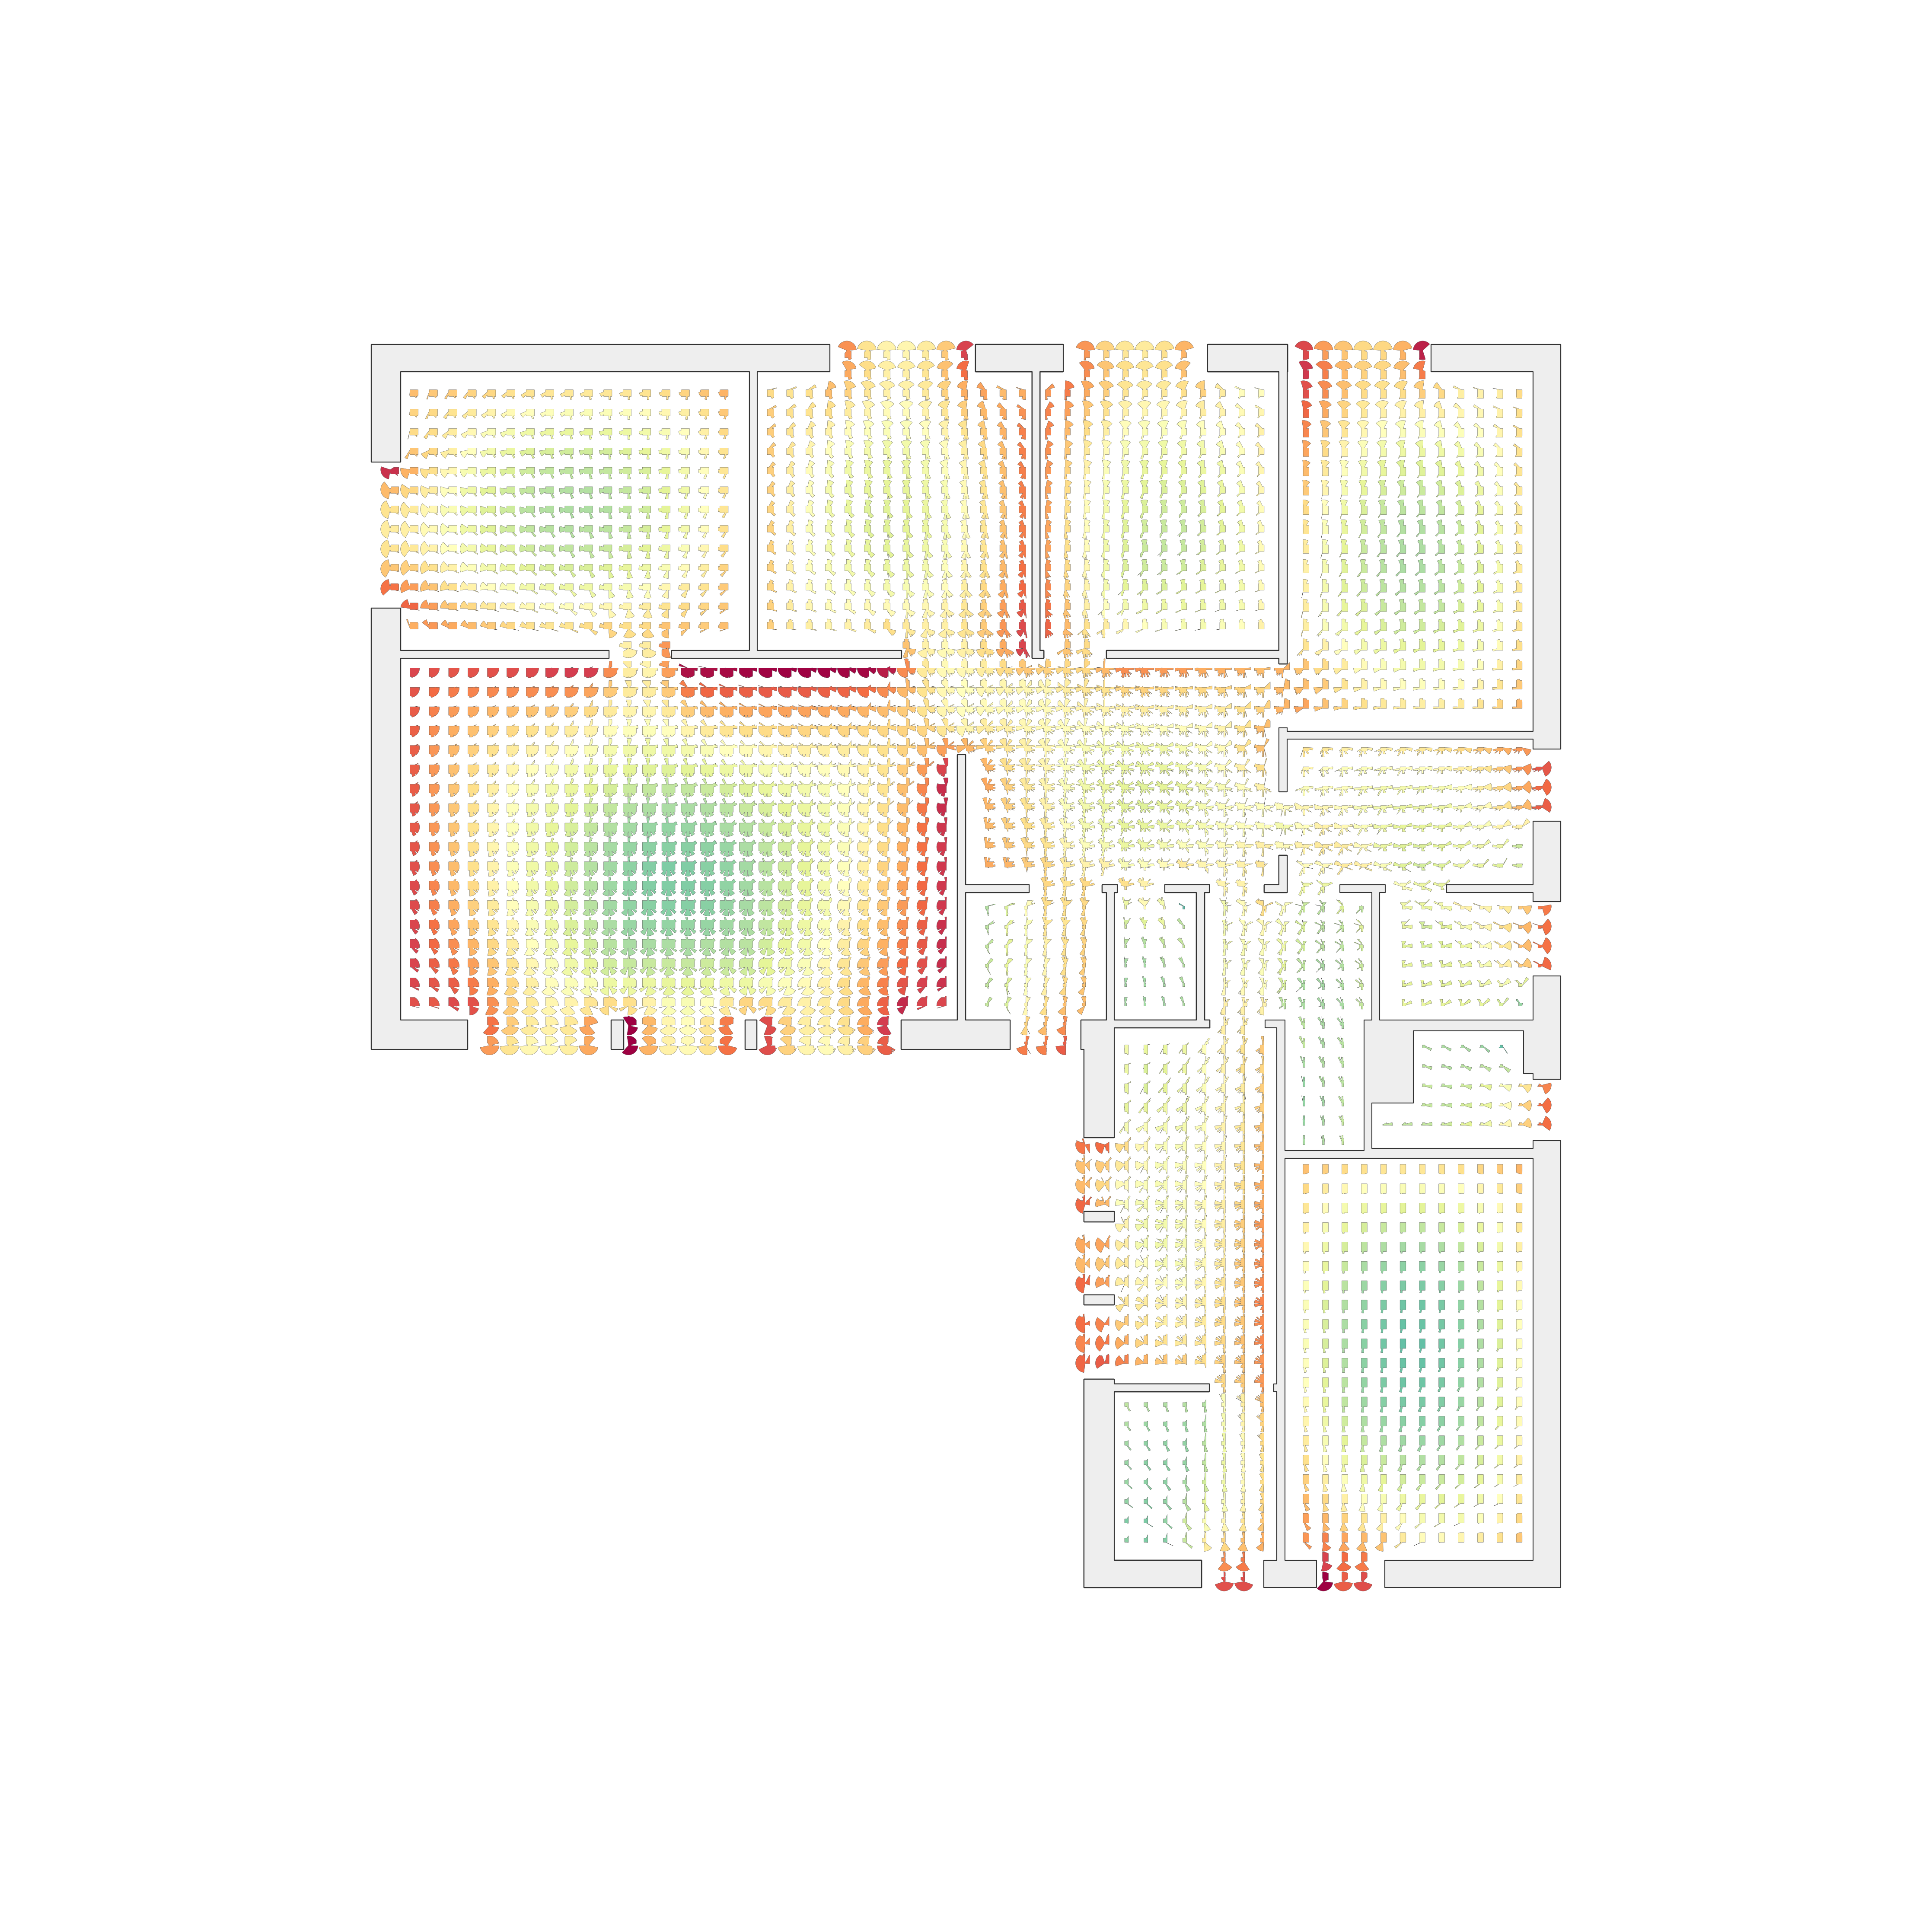

In [16]:
# plot variance map
fig, ax = plt.subplots(1,1, figsize=(15,15), dpi=300)
polylines = get_polylines(poly_txt[i])
walls = []
for polyline in polylines:
    walls.append(Polygon(polyline, True))
    p = PatchCollection(walls)
    # # p.set_color('gray')
    # p.set_edgecolor('gray')
    p.set_color('#eee')
    p.set_edgecolor('#333')
    p.set_linewidth(0.5)
    ax.add_collection(p)
# isovists
# a, b = -2, 2
colormap = plt.get_cmap('Spectral_r')
colors = colormap((values+3)/6)
isovist_polylines = []
rad_scale = 12.0
for i, isovist_ in enumerate(isovist):
    isovist_ = np.squeeze(isovist_)
    xy = isovist_to_cartesian_a(isovist_, loc[i][0], loc[i][1], rad_scale)
    isovist_polylines.append(Polygon(xy, True))
p_iso = PatchCollection(isovist_polylines)
p_iso.set_facecolor(colors)
# p_iso.set_edgecolor('none')
# p_iso.set_linewidth(0.0)
p_iso.set_edgecolor('#333')
p_iso.set_linewidth(0.1)
ax.add_collection(p_iso)
lim = 1200
ax.set_xlim(-lim,lim)
ax.set_ylim(-lim,lim)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
plt.tight_layout()


In [17]:
# iterate over dataset to get latent norm typicality score
matplotlib.use('agg')

bins = np.linspace(-4, 4, 51)

data_wsd = {'floorplan':[], 'mod_wsd':[]}

for i in tqdm(range(len(csvs))):
# for i in range(10):
    name= csvs[i].split('\\')[-1].split('.')[0]
    data_wsd['floorplan'].append(name)
    df = pd.read_csv(csvs[i])
    scale, rad, loc, isovist = get_data(df)
    isovist=np.expand_dims(isovist, axis=1)
    # latent_code = get_encoding(isovist)
    polylines = get_polylines(poly_txt[i])
    scalars, norm = get_variance(isovist)

    
    # floorplan
    fig, ax = plt.subplots(1,1, figsize=(15,15), dpi=300)

    walls = []
    for polyline in polylines:
        walls.append(Polygon(polyline, True))
        p = PatchCollection(walls)
        # # p.set_color('gray')
        # p.set_edgecolor('gray')
        p.set_color('#eee')
        p.set_edgecolor('#333')
        p.set_linewidth(0.5)
        ax.add_collection(p)
    # isovists
    # a, b = -2, 2
    colormap = plt.get_cmap('Spectral_r')
    colors = colormap((scalars+3)/6)
    isovist_polylines = []
    rad_scale = 12.0
    for i, isovist_ in enumerate(isovist):
        isovist_ = np.squeeze(isovist_)
        xy = isovist_to_cartesian_a(isovist_, loc[i][0], loc[i][1], rad_scale)
        isovist_polylines.append(Polygon(xy, True))
    p_iso = PatchCollection(isovist_polylines)
    p_iso.set_facecolor(colors)
    # p_iso.set_edgecolor('none')
    # p_iso.set_linewidth(0.0)
    p_iso.set_edgecolor('#333')
    p_iso.set_linewidth(0.1)
    ax.add_collection(p_iso)
    lim = 1200
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    plt.tight_layout()
    fig.savefig(f'{folder_plan}/{name}.jpg')
    fig.clf()
    plt.close()


    # distribution
    fig, ax = plt.subplots(1,1, figsize=(5, 3.5), dpi=150)
    p = ax.hist(X_var, bins, alpha=0.5, label='dataset', color='k', density=True)
    q = ax.hist(scalars, bins, alpha=0.5, label='floor plan', color='red', density=True)
    jsd = distance.jensenshannon(p[0], q[0])
    mod_wsd = modified_wsd(X_var, scalars, bins)
    data_wsd['mod_wsd'].append(mod_wsd)
    ax.plot([], [], ' ', label=f'mod_wsd  {mod_wsd:.2f}')
    ax.grid(True)
    ax.set_ylim(0, 0.6)
    ax.legend(loc='upper left')
    plt.tight_layout()
    fig.savefig(f'{folder_dist}/{name}_hist.jpg')
    fig.clf()
    plt.close()

    # distribution
    fig, ax = plt.subplots(1,1, figsize=(5, 3.5), dpi=150)
    p = ax.hist(X_var, bins, alpha=0.5, label='dataset', color='k', density=True, cumulative=True)
    q = ax.hist(scalars, bins, alpha=0.5, label='floor plan', color='red', density=True, cumulative=True)
    ax.plot([], [], ' ', label=f'mod_wsd  {mod_wsd:.2f}')
    ax.grid(True)
    ax.set_ylim(0, 1.2)
    ax.legend(loc='upper left')
    plt.tight_layout()
    fig.savefig(f'{folder_dist}/{name}_cu.jpg')
    fig.clf()
    plt.close()

df = pd.DataFrame(data_wsd)

df.to_csv(f'{folder}\\mod_wsd.csv')


100%|██████████| 450/450 [33:37<00:00,  4.48s/it]


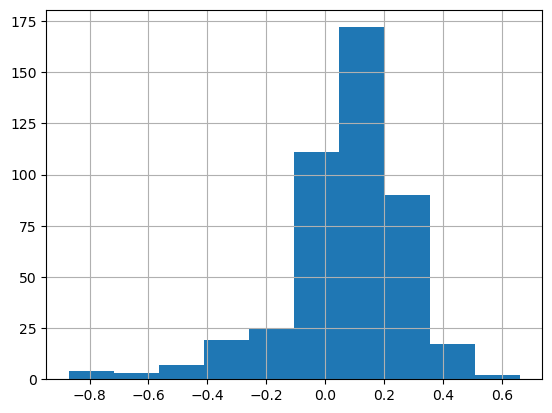

In [18]:
# visualize the distribution of typicality scores for all floor plan in the dataset
%matplotlib inline
wsd_list = data_wsd['mod_wsd']
plt.hist(wsd_list, bins=10)
plt.grid()

In [19]:
# define quartile for the distribution
q1 = np.percentile(wsd_list,  25)
q2 = np.percentile(wsd_list,  50)
q3 = np.percentile(wsd_list,  75)
median = np.median(wsd_list)
print(q1, q2, q3, median)

# lower and upper bound for outlier detection
upper_bound = q3 + 1.5*(q3-q1)
lower_bound = q1 - 1.5*(q3-q1)
print(lower_bound, upper_bound)

-0.02027397807146953 0.09169261698709379 0.19764695398469673 0.09169261698709379
-0.3471553761557189 0.5245283520689461


In [20]:
# folders for sorting
folder_plan_q0 = f'{folder}\\plan_neg_outlier'
if not os.path.isdir(folder_plan_q0):
    os.makedirs(folder_plan_q0)

folder_dist_q0 = f'{folder}\\dist_neg_outlier'
if not os.path.isdir(folder_dist_q0):
    os.makedirs(folder_dist_q0)

folder_plan_q1 = f'{folder}\\plan_q1'
if not os.path.isdir(folder_plan_q1):
    os.makedirs(folder_plan_q1)

folder_dist_q1 = f'{folder}\\dist_q1'
if not os.path.isdir(folder_dist_q1):
    os.makedirs(folder_dist_q1)

folder_plan_q2 = f'{folder}\\plan_q2'
if not os.path.isdir(folder_plan_q2):
    os.makedirs(folder_plan_q2)

folder_dist_q2 = f'{folder}\\dist_q2'
if not os.path.isdir(folder_dist_q2):
    os.makedirs(folder_dist_q2)

folder_plan_q3 = f'{folder}\\plan_q3'
if not os.path.isdir(folder_plan_q3):
    os.makedirs(folder_plan_q3)

folder_dist_q3 = f'{folder}\\dist_q3'
if not os.path.isdir(folder_dist_q3):
    os.makedirs(folder_dist_q3)

folder_plan_q4 = f'{folder}\\plan_q4'
if not os.path.isdir(folder_plan_q4):
    os.makedirs(folder_plan_q4)

folder_dist_q4 = f'{folder}\\dist_q4'
if not os.path.isdir(folder_dist_q4):
    os.makedirs(folder_dist_q4)

folder_plan_outlier = f'{folder}\\plan_pos_outlier'
if not os.path.isdir(folder_plan_outlier):
    os.makedirs(folder_plan_outlier)

folder_dist_outlier = f'{folder}\\dist_pos_outlier'
if not os.path.isdir(folder_dist_outlier):
    os.makedirs(folder_dist_outlier)

In [21]:
import shutil

# map floor plan to wsd value
fp_to_wsd = {}

for fp, wsd in zip(data_wsd['floorplan'], data_wsd['mod_wsd']):
    fp_to_wsd[fp] = wsd

# list the floor plan and distribution
plan = natsorted(glob(f'{folder_plan}/*.jpg'))
dist = natsorted(glob(f'{folder_dist}/*hist.jpg'))

# copy to different folders for each quartile 
for fp_path, dist_path in zip(plan, dist):
    name = os.path.basename(fp_path).split('.')[0]
    wsd = fp_to_wsd[name]
    wsd_clean = f'{wsd:0.3f}'.replace('.', '_')
    target_name = f'{wsd_clean}_{name}.jpg'

    if wsd <= lower_bound:
        shutil.copy(fp_path, f'{folder_plan_q0}/{target_name}')
        shutil.copy(dist_path, f'{folder_dist_q0}/{target_name}')
    elif wsd <= q1:
        shutil.copy(fp_path, f'{folder_plan_q1}/{target_name}')
        shutil.copy(dist_path, f'{folder_dist_q1}/{target_name}')
    elif wsd <= q2:
        shutil.copy(fp_path, f'{folder_plan_q2}/{target_name}')
        shutil.copy(dist_path, f'{folder_dist_q2}/{target_name}')
    elif wsd <= q3:
        shutil.copy(fp_path, f'{folder_plan_q3}/{target_name}')
        shutil.copy(dist_path, f'{folder_dist_q3}/{target_name}')
    elif wsd <= upper_bound:
        shutil.copy(fp_path, f'{folder_plan_q4}/{target_name}')
        shutil.copy(dist_path, f'{folder_dist_q4}/{target_name}')
    else:
        shutil.copy(fp_path, f'{folder_plan_outlier}/{target_name}')
        shutil.copy(dist_path, f'{folder_dist_outlier}/{target_name}')
    